## 1. color mapping
#### context engineering 전, dummy를 가지고 색 선정 함수를 정의하고자함.

In [2314]:
import pandas as pd

- KOTE 44가지 감정의 긍/부정/중립 기준 적용

In [2315]:
positive_emotions = ['감동/감탄', '고마움', '기대감', '기쁨', '뿌듯함',
'신기함/관심', '아껴주는', '안심/신뢰', '존경', '즐거움/신남', '편안/쾌적', '행복', '환영/호의',
'흐뭇함(귀여움/예쁨)',
]
negative_emotions = ['경악', '공포/무서움', '귀찮음', '당황/난처', '부끄러움', '부담/안_내킴', '불쌍함/연민', '불안/걱정', 
                     '불평/불만', '슬픔', '서러움', '안타까움/실망', '어이없음', '역겨움/징그러움', '의심/불신', '짜증', 
                     '재미없음', '절망', '죄책감', '증오/혐오', '지긋지긋', '패배/자기혐오', '한심함', '화남/분노', '힘듦/지침', '분노']
neutral_emotions = ['깨달음', '놀람', '비장함', '우쭐댐/무시함']

no_emotion = ['없음']


In [2316]:
result_emotions_contrast = {'불쌍함/연민': 0.44,
'불안/걱정': 0.56,
'서러움': 0.51,
'슬픔': 0.7,
'아껴주는' : 0.47,
'안타까움/실망': 0.31,
'없음': 0.8,
'기쁨':0.6
}

result_emotions_similar = {'불쌍함/연민': 0.44,
'불안/걱정': 0.56,
'서러움': 0.51,
'슬픔': 0.7,
'아껴주는' : 0.47,
'안타까움/실망': 0.31,
'없음': 0.8,
'죄책감':0.6
}

result_emotions_similaremotion_contrastcolor = {'불쌍함/연민': 0.44,
'불안/걱정': 0.56,
'서러움': 0.51,
'슬픔': 0.7,
'아껴주는' : 0.47,
'안타까움/실망': 0.31,
'없음': 0.8,
'분노':0.6
}

result_IRI = '멋진'

### 주감정/보조감정에 대해 KCoED데이터셋에서 주색, 보조색을 선정

In [2317]:
# 감정 출력 값 전처리 : 없음을 제거, 감정 범주화에 해당하지 않는 감정 제거 ex) 한심함
def filter_emotions(result_emotions, result_IRI):
    # Filter out the '없음' key
    filtered_emotions = {key: value for key, value in result_emotions.items() if key != '없음'}
    
    # Sort emotions by their values in descending order
    sorted_emotions = sorted(filtered_emotions.items(), key=lambda item: item[1], reverse=True)
    
    # Extract the keys of the top two emotions
    top_two_emotions = [sorted_emotions[0][0], sorted_emotions[1][0], result_IRI] if len(sorted_emotions) >= 2 else []
    
    return top_two_emotions

In [2318]:
# Example usage
## 주-보조 감정은 감정 분류 모델(KPoEM)에서, 형용사는 LLM모델이 반환.
top_emotions_contrast = filter_emotions(result_emotions_contrast, result_IRI)
top_emotions_similar = filter_emotions(result_emotions_similar, result_IRI)
top_emotions_similaremotion_contrastcolor = filter_emotions(result_emotions_similaremotion_contrastcolor, result_IRI)
print(top_emotions_contrast, top_emotions_similar, top_emotions_similaremotion_contrastcolor)  # Output: ['슬픔', '기쁨']

['슬픔', '기쁨', '멋진'] ['슬픔', '죄책감', '멋진'] ['슬픔', '분노', '멋진']


In [2319]:
# CSV 파일 경로
file_path = "korean emtion-color dataset 2.0 - SUM.csv"
# 파일 읽기 (처음엔 컬럼명을 무시하고 불러오기)
df_raw = pd.read_csv(file_path, header=None)

# 첫 번째 행을 컬럼명으로 지정
df_raw.columns = df_raw.iloc[1]
df = df_raw[2:]  # 첫 행은 이제 컬럼으로 사용했으니 제외

In [2320]:
# Function to categorize the emotion
def categorize_emotion(primary_emotion, secondary_emotion):
    # 감정 사전 정의 (예시, 필요에 따라 확장 가능)

    # 내부 분류 함수
    def classify(emotion):
        if emotion in positive_emotions:
            return "positive"
        elif emotion in negative_emotions:
            return "negative"
        elif emotion in neutral_emotions:
            return "neutral" # 아직 처리 안함.
        else:
            return "no_emotion" #아직 처리 안함.
    
    def handle_neutral_case(primary_emotion, secondary_emotion):
        # 감정이 'neutral'인 경우는 별도의 로직으로 처리
        if primary_emotion == "neutral" or secondary_emotion == "neutral":
            return "배색3"

    # 각각 분류
    primary_category = classify(primary_emotion)
    secondary_category = classify(secondary_emotion)
    
    # 'neutral'이 포함된 경우는 별도 함수로 처리
    if "neutral" in [primary_category, secondary_category] :
        print(f"Primary: {primary_category}, Secondary: {secondary_category}")
        return handle_neutral_case(primary_category, secondary_category)
    print(f"Primary: {primary_category}, Secondary: {secondary_category}")

    # 조건 비교 후 mode 반환
    if primary_category == secondary_category in ["positive", "negative"]:
        return "유사색상"
    else:
        return "대비색상"



In [2321]:
# Example usage
print(categorize_emotion(top_emotions_contrast[0],top_emotions_contrast[1]))
print(categorize_emotion(top_emotions_similar[0],top_emotions_similar[1]))
print(categorize_emotion(top_emotions_similaremotion_contrastcolor[0],top_emotions_similaremotion_contrastcolor[1]))


Primary: negative, Secondary: positive
대비색상
Primary: negative, Secondary: negative
유사색상
Primary: negative, Secondary: negative
유사색상


In [2322]:
import random

def random_color(emotion, df):
    filtered = df[(df['감정 어휘'] == emotion) & (df['평가 순위'] == '1')]
    filtered_df_array = filtered.to_dict(orient='records')

    # (예외처리) 무작위로 하나 선택
    if filtered_df_array:
        return random.choice(filtered_df_array)
    else:
        return None

In [2323]:
def get_primary_color(top_ranked_value):
    munsell_colors = ['R', 'YR', 'Y', 'GY', 'G', 'BG', 'B', 'PB', 'P', 'RP']
    total = len(munsell_colors)

    if top_ranked_value['색상약호'] not in munsell_colors:
        return "unknown_color"
    # 색상약호의 인덱스 찾기
    idx = munsell_colors.index(top_ranked_value['색상약호'])

    # 유사색상군
    similar_1_idx = [(idx - 1) % total, (idx + 1) % total]
    similar_2_idx = [(idx - 2) % total, (idx + 2) % total]

    # 대비색상군
    contrast_2_idx = [(idx - 3) % total, (idx + 3) % total]
    contrast_1_idx = [(idx - 4) % total, (idx + 4) % total]
    contrast_idx = [(idx - 5) % total]  # 보색 (정반대 5칸 거리)

    # 변환
    similar_colors_1 = [munsell_colors[i] for i in similar_1_idx]
    similar_colors_2 = [munsell_colors[i] for i in similar_2_idx]
    contrast_colors_2 = [munsell_colors[i] for i in contrast_2_idx]
    contrast_colors_1 = [munsell_colors[i] for i in contrast_1_idx]
    contrast_color = [munsell_colors[i] for i in contrast_idx]

    return {
        "center_color": top_ranked_value,
        "similar_colors_1": similar_colors_1,
        "similar_colors_2": similar_colors_2,
        "contrast_colors_1": contrast_colors_1,
        "contrast_colors_2": contrast_colors_2,
        "contrast_color": contrast_color  # 보색
    }
        

In [2324]:
def similar_mapping(primary_color_info, secondary_emotion, df):
    # secondary_ranked_value = df[df['감정 어휘'] == secondary_emotion].sort_values(by='평가 순위').iloc[0].to_dict()
    secondary_ranked_df = df[df['감정 어휘'] == secondary_emotion]
    
    similar_matches_1 = []
    similar_matches_2 = []
    similar_match_exact = []

            
    # similar_colors_1 체크
    for similar_color in primary_color_info['similar_colors_1']:
        matched = secondary_ranked_df[secondary_ranked_df['색상약호'] == similar_color]
        if not matched.empty:
            similar_matches_1.append(matched)

    # similar_colors_2 체크
    for similar_color in primary_color_info['similar_colors_2']:
        matched = secondary_ranked_df[secondary_ranked_df['색상약호'] == similar_color]
        if not matched.empty:
            similar_matches_2.append(matched)
            
    # same_color (동일색) 체크
    same_color = primary_color_info['center_color']  # 단일 값 리스트 #주색은 미리 딕셔너리로 보관됨. 그대로 가져옴.
    matched_exact = secondary_ranked_df[secondary_ranked_df['색상약호'] == same_color]
    if not matched_exact.empty:
        similar_match_exact.append(matched_exact)
    
    # 유사색상군1과 유사색상군2 중 하나라도 일치하는 경우.
    if similar_matches_1 or similar_matches_2: 
        if similar_matches_1: # 대비색상군1을 우선 선정.
            similar_matches_1_df = pd.concat(similar_matches_1).to_dict(orient='records')
            # print(similar_matches_1_df)
            return {"primary_color" : primary_color_info['center_color'],
                    "secondary_color" : min(similar_matches_1_df, key=lambda x: x['평가 순위'])}
        else: #대비색상군1이 없고, 대비색상군2가 있는 경우
            similar_matches_2_df = pd.concat(similar_matches_2).to_dict(orient='records')
            # print(similar_matches_2_df)
            return {"primary_color" : primary_color_info['center_color'],
                    "secondary_color" :min(similar_matches_2_df, key=lambda x: x['평가 순위'])}
            
    # 동일색이 있는경우
    if similar_match_exact:
        similar_dicts = similar_match_exact[0].to_dict(orient='records')
        return {"primary_color" : primary_color_info['center_color'],
                "secondary_color" : min(similar_dicts, key=lambda x: x['평가 순위'])} # '평가 순위'가 가장 높은 값 (숫자가 클수록 높은 순위라면 ↓)
        
    # 유사색상이 없는 경우
    pure_secondary_colors = random_color(secondary_emotion, df)
    return {"primary_color" : primary_color_info['center_color'], "secondary_color" :pure_secondary_colors}

In [2325]:
def contrast_mapping(primary_color_info, secondary_emotion, df):
    secondary_ranked_df = df[df['감정 어휘'] == secondary_emotion]
        
    contrast_matches_1 = []
    contrast_matches_2 = []
    contrast_match_exact = []

            
    # contrast_colors_1 체크
    for contrast_color in primary_color_info['contrast_colors_1']:
        matched = secondary_ranked_df[secondary_ranked_df['색상약호'] == contrast_color]
        if not matched.empty:
            contrast_matches_1.append(matched)

    # contrast_colors_2 체크
    for contrast_color in primary_color_info['contrast_colors_2']:
        matched = secondary_ranked_df[secondary_ranked_df['색상약호'] == contrast_color]
        if not matched.empty:
            contrast_matches_2.append(matched)
            
    # contrast_color (보색) 체크
    contrast_color = primary_color_info['contrast_color'][0]  # 단일 값 리스트
    matched_exact = secondary_ranked_df[secondary_ranked_df['색상약호'] == contrast_color]
    if not matched_exact.empty:
        contrast_match_exact.append(matched_exact)

    #출력
    # print("대비색상군1과 일치하는 색상 ↓")
    # print(pd.concat(contrast_matches_1) if contrast_matches_1 else "대비색상군1 없음")

    # print("\n대비색상군2와 일치하는 색상 ↓")
    # print(pd.concat(contrast_matches_2) if contrast_matches_2 else "대비색상군2 없음")

    # print("\n보색과 정확히 일치하는 색상 ↓")
    # print(pd.concat(contrast_match_exact) if contrast_match_exact else "보색 일치 항목 없음")
    
    #보색이 정확히 일치하는 경우
    if contrast_match_exact:
        contrast_dicts = contrast_match_exact[0].to_dict(orient='records')
        return {"primary_color" : primary_color_info['center_color'],
                "secondary_color" : min(contrast_dicts, key=lambda x: x['평가 순위'])} # '평가 순위'가 가장 높은 값 (숫자가 클수록 높은 순위라면 ↓)
    
    # 대비색상군1과 대비색상군2 중 하나라도 일치하는 경우.
    if contrast_matches_1 or contrast_matches_2: 
        if contrast_matches_1: # 대비색상군1을 우선 선정.
            contrast_matches_1_df = pd.concat(contrast_matches_1).to_dict(orient='records')
            # print(contrast_matches_1_df)
            return {"primary_color" : primary_color_info['center_color'],
                    "secondary_color" : min(contrast_matches_1_df, key=lambda x: x['평가 순위'])}
        else: #대비색상군1이 없고, 대비색상군2가 있는 경우
            contrast_matches_2_df = pd.concat(contrast_matches_2).to_dict(orient='records')
            # print(contrast_matches_2_df)
            return {"primary_color" : primary_color_info['center_color'],
                    "secondary_color" :min(contrast_matches_2_df, key=lambda x: x['평가 순위'])}
    # 대비색상이 없는 경우
    pure_secondary_colors = random_color(secondary_emotion, df)
    return {"primary_color" : primary_color_info['center_color'], "secondary_color" :pure_secondary_colors}  # '평가 순위'가 가장 높은 값 (숫자가 클수록 높은 순위라면 ↓)

In [2326]:
def get_sencondary_color(primary_color_info, secondary_emotion, mode_colors, df):
    # 유사색상 모드일 때
    if mode_colors == "유사색상":
        return similar_mapping(primary_color_info, secondary_emotion, df)
    # 대비색상 모드일 때
    elif mode_colors == "대비색상": 
        return contrast_mapping(primary_color_info, secondary_emotion, df)
        
    # 예외처리 : 대비색상, 대비색상군1, 대비색상군2가 전부 없는 경우

In [2327]:
def define_colors(primary_emotion, secondary_emotion, df):
    mode_colors = categorize_emotion(primary_emotion, secondary_emotion)
    # top_ranked_value = df[df['감정 어휘'] == primary_emotion].sort_values(by='평가 순위').iloc[0].to_dict()
    # top_ranked_value = df[df['감정 어휘'] == primary_emotion].sort_values(by='평가 순위')
    # filtered = df[(df['감정 어휘'] == primary_emotion) & (df['평가 순위'] == 1)]
    
    primary_color_data = random_color(primary_emotion, df) # 무작위로 하나 선택
    primary_color_info_test= get_primary_color(primary_color_data)
    return get_sencondary_color(primary_color_info_test, secondary_emotion, mode_colors, df)
    

In [2328]:
colors_contrast = define_colors(top_emotions_contrast[0],top_emotions_contrast[1], df) # 주감정과 보조감정, KCoED 데이터셋
colors_contrast


Primary: negative, Secondary: positive


{'primary_color': {'감정id': '24',
  '감정 어휘': '슬픔',
  '평가 순위': '1',
  'R': '76',
  'G': '87',
  'B': '101',
  '샘플': nan,
  '출처/참고문헌': '김애경,and 오윤경. "긍정 및 부정 정서어휘에 대한 색 반응 연구." 조형미디어학 19.1 (2016): 59-66.',
  '출처/참고문헌2': 'https://gist.github.com/hidex7777/5268753',
  '색상': '남색',
  '색상약호': 'PB',
  '색상 온도': 'Cold',
  nan: nan},
 'secondary_color': {'감정id': '17',
  '감정 어휘': '기쁨',
  '평가 순위': '1',
  'R': '238',
  'G': '201',
  'B': '0',
  '샘플': nan,
  '출처/참고문헌': '김애경,and 오윤경. "긍정 및 부정 정서어휘에 대한 색 반응 연구." 조형미디어학 19.1 (2016): 59-66.',
  '출처/참고문헌2': 'https://gist.github.com/hidex7777/5268700',
  '색상': '노랑',
  '색상약호': 'Y',
  '색상 온도': 'Warm',
  nan: nan}}

In [2329]:
colors_similar = define_colors(top_emotions_similar[0],top_emotions_similar[1], df) # 주감정과 보조감정, KCoED 데이터셋
colors_similar

Primary: negative, Secondary: negative


{'primary_color': {'감정id': '24',
  '감정 어휘': '슬픔',
  '평가 순위': '1',
  'R': '76',
  'G': '87',
  'B': '101',
  '샘플': nan,
  '출처/참고문헌': '김애경,and 오윤경. "긍정 및 부정 정서어휘에 대한 색 반응 연구." 조형미디어학 19.1 (2016): 59-66.',
  '출처/참고문헌2': 'https://gist.github.com/hidex7777/5268753',
  '색상': '남색',
  '색상약호': 'PB',
  '색상 온도': 'Cold',
  nan: nan},
 'secondary_color': {'감정id': '27',
  '감정 어휘': '죄책감',
  '평가 순위': '1',
  'R': '67',
  'G': '40',
  'B': '72',
  '샘플': nan,
  '출처/참고문헌': '김애경,and 오윤경. "긍정 및 부정 정서어휘에 대한 색 반응 연구." 조형미디어학 19.1 (2016): 59-66.',
  '출처/참고문헌2': 'https://gist.github.com/hidex7777/5268770',
  '색상': '보라',
  '색상약호': 'P',
  '색상 온도': 'Neutral',
  nan: nan}}

In [2330]:
colors_similar_contrast = define_colors(top_emotions_similaremotion_contrastcolor[0],top_emotions_similaremotion_contrastcolor[1], df) # 주감정과 보조감정, KCoED 데이터셋
colors_similar_contrast

Primary: negative, Secondary: negative


{'primary_color': {'감정id': '24',
  '감정 어휘': '슬픔',
  '평가 순위': '1',
  'R': '76',
  'G': '87',
  'B': '101',
  '샘플': nan,
  '출처/참고문헌': '김애경,and 오윤경. "긍정 및 부정 정서어휘에 대한 색 반응 연구." 조형미디어학 19.1 (2016): 59-66.',
  '출처/참고문헌2': 'https://gist.github.com/hidex7777/5268753',
  '색상': '남색',
  '색상약호': 'PB',
  '색상 온도': 'Cold',
  nan: nan},
 'secondary_color': {'감정id': '28',
  '감정 어휘': '분노',
  '평가 순위': '1',
  'R': '208',
  'G': '47',
  'B': '72',
  '샘플': nan,
  '출처/참고문헌': '김애경,and 오윤경. "긍정 및 부정 정서어휘에 대한 색 반응 연구." 조형미디어학 19.1 (2016): 59-66.',
  '출처/참고문헌2': 'https://gist.github.com/hidex7777/5268773',
  '색상': '빨강',
  '색상약호': 'R',
  '색상 온도': 'Warm',
  nan: nan}}

### 주색/보조색을 가지고 컬러 변환

In [2331]:
import colorsys

In [2332]:
def rgb_to_hsb(rgb_dict):
    # 문자열 RGB 값을 정수로 변환
    r = int(rgb_dict['R']) / 255.0
    g = int(rgb_dict['G']) / 255.0
    b = int(rgb_dict['B']) / 255.0

    # RGB → HSB (HSV)
    h, s, v = colorsys.rgb_to_hsv(r, g, b)

    # HSB 값 반환 (0~360, 0~100, 0~100)
    return {
        'H': round(h * 360), #반올림
        'S': round(s * 100),
        'B': round(v * 100)
    }

In [2333]:
processed_primary_color1 = rgb_to_hsb(colors_similar['primary_color'])
processed_secondary_color1 = rgb_to_hsb(colors_similar['secondary_color'])

In [2334]:
processed_primary_color2 = rgb_to_hsb(colors_contrast['primary_color'])
processed_secondary_color2 = rgb_to_hsb(colors_contrast['secondary_color'])

In [2335]:
processed_primary_color3 = rgb_to_hsb(colors_similar_contrast['primary_color'])
processed_secondary_color3 = rgb_to_hsb(colors_similar_contrast['secondary_color'])

### IRI 스케일 다루기

In [2336]:
# CSV 파일 경로
file_path_IRI = "임이로_학위논문_korean emtion-color dataset 2.0 - IRI-형용사스케일.csv"
# 파일 읽기 (처음엔 컬럼명을 무시하고 불러오기)
df_raw_IRI = pd.read_csv(file_path_IRI, header=None)

# 첫 번째 행을 컬럼명으로 지정
df_raw_IRI.columns = df_raw_IRI.iloc[1]
df_IRI = df_raw_IRI[2:]  # 첫 행은 이제 컬럼으로 사용했으니 제외

#### 형용사 정리

In [2337]:

# 필요한 열만 추출 ('형용사군', '형용사id', '형용사')
adjective_df = df_IRI[['형용사군', '형용사id', '형용사']].dropna()

# 형용사id를 숫자로 정리 (필요한 경우)
adjective_df['형용사id'] = adjective_df['형용사id'].astype(int)

# 형용사군별로 그룹화하여 리스트로 변환
grouped_adjectives = (
    adjective_df.groupby('형용사군')
    .apply(lambda g: list(g['형용사']))
    .to_dict()
)

/tmp/ipykernel_897/43394017.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: list(g['형용사']))


#### 추출한 감정형용사의 형용사군 검색

In [2338]:
def find_adjective_group(adjective, grouped_dict):
    """
    주어진 형용사가 속한 형용사군(key)을 반환.
    """
    for group, adjectives in grouped_dict.items():
        if adjective in adjectives:
            return group
    return None  # 못 찾았을 경우

In [2339]:
group_name = find_adjective_group(result_IRI, grouped_adjectives)

if group_name:
    print(f"형용사 '{result_IRI}'는 '{group_name}' 형용사군에 속합니다.")
else:
    print(f"형용사 '{result_IRI}'는 어떤 형용사군에도 속하지 않습니다.")

형용사 '멋진'는 '우아한' 형용사군에 속합니다.


In [2340]:
# CSV 파일 경로
file_path_IRI_colors = "임이로_학위논문_korean emtion-color dataset 2.0 - IRI-배색스케일.csv"
# 파일 읽기 (처음엔 컬럼명을 무시하고 불러오기)
df_raw_IRI_colors = pd.read_csv(file_path_IRI_colors, header=None)

# 첫 번째 행을 컬럼명으로 지정
df_raw_IRI_colors.columns = df_raw_IRI_colors.iloc[1]
df_IRI_colors = df_raw_IRI_colors[2:]  # 첫 행은 이제 컬럼으로 사용했으니 제외

# ----------------------------------------
# 색상약호가 'White' 또는 'Black'인 행 제거
# ----------------------------------------

# '색상약호' 컬럼에 NaN이 있을 수 있으므로 fillna 처리
df_IRI_colors = df_IRI_colors[~df_IRI_colors['색상약호'].fillna('').isin(['White', 'Black'])]

In [2341]:
IRI_colors_df = df_IRI_colors[df_IRI_colors['형용사군'] == group_name]
# '배색그룹id' 컬럼에서 고유값만 추출
palette_ids = IRI_colors_df['배색그룹id'].dropna().unique()

# 랜덤 선택
if len(palette_ids) > 0:
    chosen_palette_id = random.choice(palette_ids)
    print(f"선택된 배색그룹id: {chosen_palette_id}")
else:
    chosen_palette_id = None
    print("배색그룹id가 존재하지 않습니다.")
    
# chosen_palette_id에 해당하는 행만 추출
palette_df = IRI_colors_df[IRI_colors_df['배색그룹id'] == chosen_palette_id]

선택된 배색그룹id: 3


In [2342]:
palette_df

1,형용사군id,형용사군,배색그룹id,단일색상 id,R,G,B,Hue,Saturation,Brightness,색상,색상약호,배색방법,NaN,NaN
74,7,우아한,3,1,103,103,103,81,0,40,회색,Gray,NaN,NaN,NaN
75,7,우아한,3,2,197,165,138,26,29,77,주황,YR,NaN,NaN,NaN
76,7,우아한,3,3,79,104,82,127,23,40,초록,G,NaN,NaN,NaN


In [2343]:
def choose_color_pair(palette_df):
    # 사용할 쌍 정의 (우선순위 순서)
    priority_pairs = [(1, 2), (2, 3), (2, 1), (3, 2)]
    fallback_pairs = [(1, 3), (3, 1)]

    # 현재 데이터프레임에 존재하는 단일색상 id 추출
    available_ids = set(palette_df['단일색상 id'].dropna().astype(int).unique())

    # 가능한 쌍 필터링
    valid_priority_pairs = [pair for pair in priority_pairs if pair[0] in available_ids and pair[1] in available_ids]
    valid_fallback_pairs = [pair for pair in fallback_pairs if pair[0] in available_ids and pair[1] in available_ids]

    # 랜덤 선택
    if valid_priority_pairs:
        return random.choice(valid_priority_pairs)
    elif valid_fallback_pairs:
        return random.choice(valid_fallback_pairs)
    else:
        return None

In [2344]:
def get_palette_dicts(palette_df):
    """
    palette_result 튜플 (id1, id2)에 대해 해당하는 단일색상id 행을
    각각 dictionary로 반환
    """
    palette_result = choose_color_pair(palette_df)
    id1, id2 = palette_result

    # '단일색상 id' 컬럼이 float일 가능성 있으므로 int로 캐스팅
    df_cast = palette_df.copy()
    df_cast['단일색상 id'] = df_cast['단일색상 id'].astype(int)

    # 각 색상 id에 대응하는 행 추출 후 dict 변환
    primary_row = df_cast[df_cast['단일색상 id'] == id1].iloc[0].to_dict()
    secondary_row = df_cast[df_cast['단일색상 id'] == id2].iloc[0].to_dict()

    return {'primary_palette' : primary_row, 'secondary_palette' : secondary_row}

In [2345]:
palette_result = get_palette_dicts(palette_df)

In [2346]:
def update_saturation_brightness(processed_primary_color, processed_secondary_color, palette_result):
    """
    processed_primary_color와 processed_secondary_color의 S, B 값을
    palette_result의 S, B 값으로 업데이트합니다.
    """
    processed_primary_color['S'] = palette_result['primary_palette']['Saturation']
    processed_primary_color['B'] = palette_result['primary_palette']['Brightness']
    processed_secondary_color['S'] = palette_result['secondary_palette']['Saturation']
    processed_secondary_color['B'] = palette_result['secondary_palette']['Brightness']

    return {'updated_primary_color': processed_primary_color,
            'updated_secondary_color': processed_secondary_color
            }

In [2347]:
updated_colors1 = update_saturation_brightness(processed_primary_color1, processed_secondary_color1, palette_result)
updated_colors2 = update_saturation_brightness(processed_primary_color2, processed_secondary_color2, palette_result)
updated_colors3 = update_saturation_brightness(processed_primary_color3, processed_secondary_color3, palette_result)

In [2348]:
updated_colors1

{'updated_primary_color': {'H': 214, 'S': '29', 'B': '77'},
 'updated_secondary_color': {'H': 291, 'S': '0', 'B': '40'}}

In [2349]:
import matplotlib.pyplot as plt

In [2350]:
def hsb_to_rgb_tuple(hsb):
    h = int(hsb['H']) / 360
    s = int(hsb['S']) / 100
    v = int(hsb['B']) / 100
    r, g, b = colorsys.hsv_to_rgb(h, s, v)
    return (r, g, b)  # matplotlib uses 0-1 float RGB

In [2351]:
def emotion_to_colors(top_emotions, color_results):
# RGB 변환
    rgb1 = hsb_to_rgb_tuple(color_results['updated_primary_color'])
    rgb2 = hsb_to_rgb_tuple(color_results['updated_secondary_color'])

    # 시각화
    fig, ax = plt.subplots(1, 2, figsize=(4, 2))
    ax[0].imshow([[rgb1]])
    ax[0].set_title("Primary Color")
    ax[0].axis('off')

    ax[1].imshow([[rgb2]])
    ax[1].set_title("Secondary Color")
    ax[1].axis('off')
    
    # 한글 폰트 설정
    plt.rcParams['font.family'] = 'NanumGothic'

    # 경고 방지
    plt.rcParams['axes.unicode_minus'] = False

    plt.suptitle(f"{top_emotions[2]}, {top_emotions[0]}과(와) {top_emotions[1]}", fontsize=14)
    plt.tight_layout()
    plt.show()

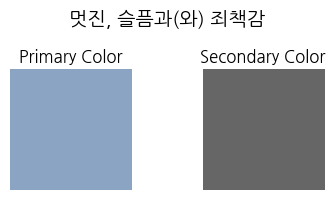

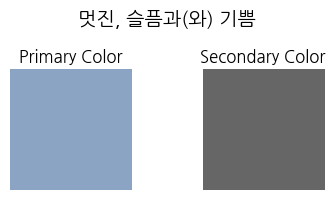

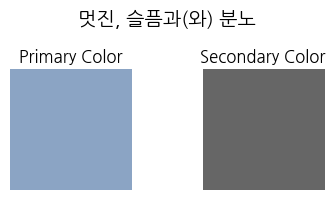

In [2352]:
emotion_to_colors(top_emotions_similar, updated_colors1)
emotion_to_colors(top_emotions_contrast, updated_colors2)
emotion_to_colors(top_emotions_similaremotion_contrastcolor, updated_colors3)